<a href="https://colab.research.google.com/github/Sarvani-5/KneeOA_DL/blob/main/MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading MedicalExpert-I...
Processing 0Normal... Loaded 514 samples
Processing 1Doubtful... Loaded 477 samples
Processing 2Mild... Loaded 232 samples
Processing 3Moderate... Loaded 221 samples
Processing 4Severe... Loaded 206 samples

Loading MedicalExpert-II...
Processing 0Normal... Loaded 504 samples
Processing 1Doubtful... Loaded 488 samples
Processing 2Mild... Loaded 232 samples
Processing 3Moderate... Loaded 221 samples
Processing 4Severe... Loaded 206 samples

Class distribution in combined dataset:
0Normal: 1018 samples
1Doubtful: 965 samples
2Mild: 464 samples
3Moderate: 442 samples
4Severe: 412 samples

Training samples: 2640
Test samples: 661
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    32,113,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,506,821 (131.63 MB)

 Trainable params: 32,247,301 (123.01 MB)

 Non-trainable params: 2,259,520 (8.62 MB)


Training top layers with frozen MobileNetV2 base...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.3474 - loss: 2.1144
Epoch 1: val_accuracy improved from -inf to 0.56732, saving model to /content/drive/MyDrive/KneeOA/mobilenetv2_best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 67s 630ms/step - accuracy: 0.3482 - loss: 2.1113 - val_accuracy: 0.5673 - val_loss: 1.2722 - learning_rate: 1.0000e-04
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.5075 - loss: 1.4588
Epoch 2: val_accuracy improved from 0.56732 to 0.67020, saving model to /content/drive/MyDrive/KneeOA/mobilenetv2_best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 34s 414ms/step - accuracy: 0.5076 - loss: 1.4589 - val_accuracy: 0.6702 - val_loss: 0.9268 - learning_rate: 1.0000e-04
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.5745 - loss: 1.2267
Epoch 3: val_accuracy improved from 0.67020 to 0.68684, saving model to /content/drive/MyDrive/KneeOA/mobilenetv2_best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 497ms/step - accuracy: 0.5744

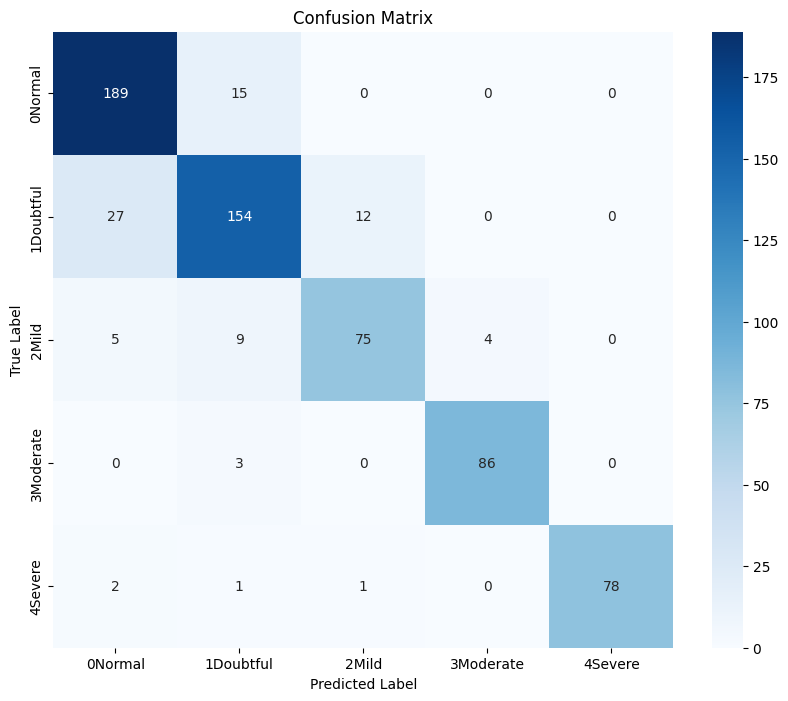


Classification Report:
              precision    recall  f1-score   support

     0Normal       0.85      0.93      0.89       204
   1Doubtful       0.85      0.80      0.82       193
       2Mild       0.85      0.81      0.83        93
   3Moderate       0.96      0.97      0.96        89
     4Severe       1.00      0.95      0.97        82

    accuracy                           0.88       661
   macro avg       0.90      0.89      0.89       661
weighted avg       0.88      0.88      0.88       661



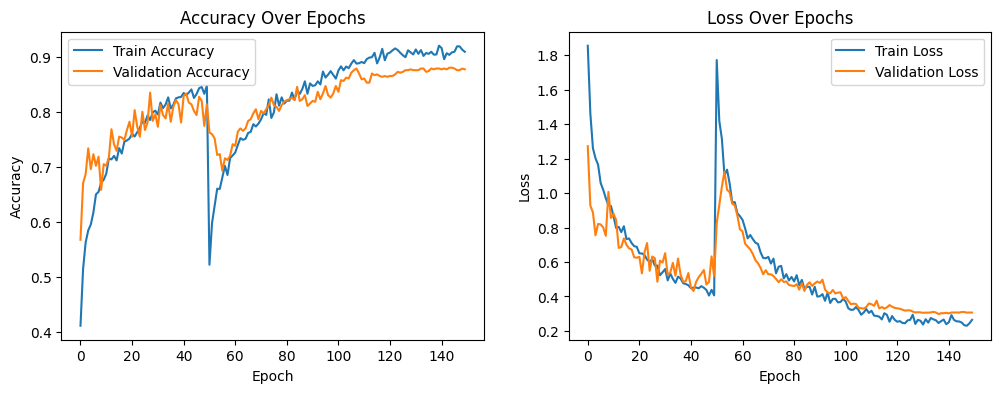


Sample predictions on test set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


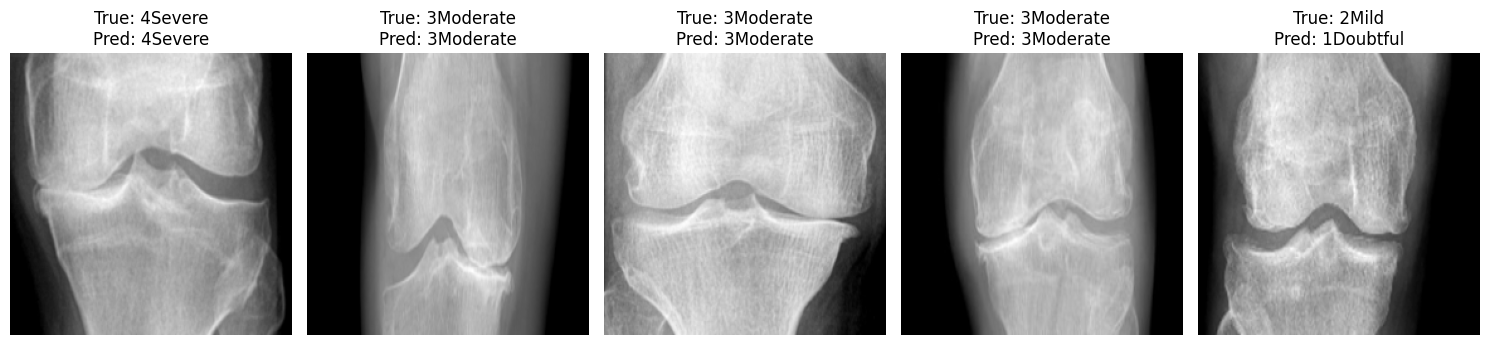


The best model has been saved to: /content/drive/MyDrive/KneeOA/mobilenetv2_best_model.keras


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# Define class mapping
knee_classes = {'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4}
class_names = list(knee_classes.keys())

# Enhanced data loader that combines both datasets
def load_combined_data(exp1_path, exp2_path, image_size=224):  # MobileNetV2 typically uses 224x224
    X, y = [], []

    # Load MedicalExpert-I
    print("Loading MedicalExpert-I...")
    for class_name, class_idx in knee_classes.items():
        class_path = os.path.join(exp1_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Missing directory {class_path}")
            continue

        print(f"Processing {class_name}...", end=' ')
        count = 0
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img = cv2.resize(img, (image_size, image_size))
                # Convert grayscale to RGB by repeating the channel
                img_rgb = cv2.merge([img, img, img])
                X.append(img_rgb)
                y.append(class_idx)
                count += 1
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        print(f"Loaded {count} samples")

    # Load MedicalExpert-II
    print("\nLoading MedicalExpert-II...")
    for class_name, class_idx in knee_classes.items():
        class_path = os.path.join(exp2_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Missing directory {class_path}")
            continue

        print(f"Processing {class_name}...", end=' ')
        count = 0
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img = cv2.resize(img, (image_size, image_size))
                # Convert grayscale to RGB by repeating the channel
                img_rgb = cv2.merge([img, img, img])
                X.append(img_rgb)
                y.append(class_idx)
                count += 1
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        print(f"Loaded {count} samples")

    return np.array(X), np.array(y)

# Paths to your datasets - UPDATE THESE
medical_expert_I_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-I"
medical_expert_II_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-II"

# Load combined data
X, y = load_combined_data(medical_expert_I_path, medical_expert_II_path)

# Check class distribution
print("\nClass distribution in combined dataset:")
for class_name, class_idx in knee_classes.items():
    print(f"{class_name}: {np.sum(y == class_idx)} samples")

# Convert to float32 and preprocess for MobileNetV2
X = X.astype('float32')
X = preprocess_input(X)  # Preprocess for MobileNetV2
y = to_categorical(y, num_classes=5)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

# Build model using MobileNetV2
def build_mobilenetv2_model():
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        alpha=1.0  # Controls the width of the network
    )

    # Freeze the base model layers first
    base_model.trainable = False

    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model, base_model

model, base_model = build_mobilenetv2_model()
model.summary()

# Define the single best model path
best_model_path = '/content/drive/MyDrive/KneeOA/mobilenetv2_best_model.keras'

# Callbacks
callbacks = [
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6, verbose=1),
    ModelCheckpoint(
        filepath=best_model_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# First phase - train with frozen base model
print("\nTraining top layers with frozen MobileNetV2 base...")
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# Unfreeze some layers for fine-tuning
print("\nUnfreezing later MobileNetV2 layers for fine-tuning...")
base_model.trainable = True
# MobileNetV2 has a different structure - we'll freeze earlier layers but unfreeze later ones
# Keep approximately the first 100 layers frozen (adjust as needed)
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nFine-tuning model...")
history_fine = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=16),
    epochs=150,
    initial_epoch=50,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# Combine histories
combined_history = {}
for key in history.history:
    combined_history[key] = history.history[key] + history_fine.history[key]

# Load the best model for evaluation
print(f"\nLoading the best model from {best_model_path}")
best_model = load_model(best_model_path)

# Evaluate the best model
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/drive/MyDrive/KneeOA/mobilenetv2_confusion_matrix.png')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Train Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/KneeOA/mobilenetv2_training_history.png')
plt.show()

# Sample predictions
def predict_sample_images(model, X_test, y_test, num_samples=5):
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices, 1):
        image = X_test[idx]
        true_class = np.argmax(y_test[idx])

        # Make prediction
        pred_probs = model.predict(np.expand_dims(image, axis=0))
        pred_class = np.argmax(pred_probs)

        # Convert image back for display
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to 0-1

        plt.subplot(1, num_samples, i)
        plt.imshow(image)
        plt.title(f"True: {class_names[true_class]}\nPred: {class_names[pred_class]}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/KneeOA/mobilenetv2_sample_predictions.png')
    plt.show()

# Display sample predictions
print("\nSample predictions on test set:")
predict_sample_images(best_model, X_test, y_test, num_samples=5)

print(f"\nThe best model has been saved to: {best_model_path}")